## Random Forest

Author: Elisa Warner
Created: 4/16/2019

Purpose: Check results of SVM against stock data

Change Record:
6/11/2019 Made Time-Cross Validation be non-overlapping

## Confusion Table Function

In [324]:
###########################
## Create confusion table
###########################

import matplotlib
import matplotlib.pyplot as plt

def prediction_box(predictions, ground_truth):
    ## results
    result = {'tp':0, 'fp':0, 'tn':0, 'fn':0}

    for i in range(len(predictions)):
        #print(pred_test[i], y[i])
        if predictions[i] == ground_truth[i] and ground_truth[i] == 1:
            result['tp'] = result.get('tp', 0) + 1
        elif predictions[i] == ground_truth[i] and ground_truth[i] == 0:
            result['tn'] = result.get('tn', 0) + 1
        elif predictions[i] != ground_truth[i] and ground_truth[i] == 1:
            result['fn'] = result.get('fn', 0) + 1
        else:
            result['fp'] = result.get('fp', 0) + 1

    m = np.array([[result['tp'], result['fn']],[result['fp'],result['fn']]])
    fig, ax = plt.subplots()
    im = ax.imshow(m, cmap='Pastel1')
    
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            plt.text(j, i, "{:.2f}".format(m[i,j]), ha="center", va="center")
            plt.title('Predictions for Test Set')
            ax.set_xticks([0, 1])
            ax.set_yticks([0, 1])
            ax.set_xticklabels([1, 0])
            ax.set_yticklabels([1, 0])
            plt.ylabel('Ground Truth')
            plt.xlabel('Prediction')

### Remove Missing

In [325]:
def remove_missing(df):
    for col in list(df):
        colvals = df[col].values
        new_colvals = []
        for i in range(len(colvals)):
            if colvals[i] == '.':
                print('Missing found')
                new_colvals.append(colvals[i-1])
            elif pd.isnull(colvals[i]):
                print('nan found')
                new_colvals.append(colvals[i-1])
            else:
                new_colvals.append(colvals[i])
        df[col] = new_colvals
    
    return df

In [326]:
def remove_missing_horz(df):
    new_df = pd.DataFrame()
    for i in range(df.shape[0]):
        row = list(df.iloc[i].values)

        if '.' in row:
            idx_list = [i for i in range(len(row)) if row[i] == ('.')]
            for idx in idx_list:
                row[idx] = row[idx - 1]

        idx_list = [i for i in range(len(row)) if pd.isnull(row[i]) == True]
        for idx in idx_list:
            row[idx] = row[idx - 1]
            
        new_df = new_df.append(pd.DataFrame(row).T, ignore_index = True)
    
    return new_df

## 1. Load Data

In [327]:
#!pip3 install -U scikit-learn scipy matplotlib

In [328]:
import pandas as pd
from sklearn import svm
import numpy as np

In [343]:
file1 = "./Combined_Sets_from_Revised.csv" #"Draft_Google_Shorter.csv" #Removed Missing

train_pd = pd.read_csv(file1)
train_pd.shape

(7120, 422)

In [344]:
#train_pd[5902:7100] # Google Trends part

In [345]:
train_pd = train_pd #[5902:7100]

train = np.array(train_pd)
train.shape

(7120, 422)

In [346]:
train = train[:, :148] # drop google columns

In [347]:
train = train[2:,1:] # drop date
train

array([[1, 173.199997, 8.13, ..., 390.4, 395.35, 398.0],
       [1, 172.779999, 8.16, ..., 395.35, 398.0, 403.7],
       [1, 171.169998, 8.25, ..., 398.0, 403.7, 383.5],
       ...,
       [4, 1697.430054, 2.512, ..., 1304.65, 1296.15, 1286.75],
       [4, 1706.280029, 2.501, ..., 1296.15, 1286.75, 1283.75],
       [4, 1707.6700440000004, 2.519, ..., 1286.75, 1283.75, 1276.1]],
      dtype=object)

## 2. Time-Series Cross validation

In [358]:
def time_cross(array, time_shift = 0, size_train_set = 365, size_val_set = 100, set_shift = 0):
    np.random.seed(100)
    label_idx = 0

    if time_shift == 0:
        time_shift = size_train_set + size_val_set + set_shift
        
    train_size = train.shape
    j = 0
    group = 1
    end = train_size[0]
    trainDataPartition = [] # list
    valDataPartition = []

    #print(size_train_set, size_val_set, train_size[0])
    while j + (size_train_set + size_val_set + set_shift) < train_size[0]:
        trainset = []
        valset = []

        trainset = train[j:j+size_train_set, :] # array
        valset = train[j+size_train_set+1+set_shift:j+size_train_set+size_val_set+set_shift, :]

        trainDataPartition.append(trainset)
        valDataPartition.append(valset)
    
        group = group+1;
        j = j + time_shift


    # make last set -- decide if you want to throw out or adjust this set
    print('Last set:', j, j+size_train_set)
    trainset = train[j:j+size_train_set, :]
    valset = train[j+size_train_set+1+set_shift:end, :]
    #print(trainset)
    #print(valset)
    
    trainDataPartition.append(trainset)
    valDataPartition.append(valset)

    
    ### Optional: stratify
    revised_trainDataPartition = []
    revised_valDataPartition = []
    
    for i in range(len(trainDataPartition)):
        trainset = trainDataPartition[i]
        valset = valDataPartition[i] # Do the same for validation set
        
        print(trainset.shape[0], valset.shape[0])
        records = trainset[:,0] # record of labels for training set
        records_val = valset[:, 0] # record of labels for validation set
        #print(sum(records == 1), sum(records == 0))
        #print(sum(records_val == 1), sum(records_val == 0))
        
        ############ FOR TRAINING SET ################
        if sum(records == 1) == 0 or sum(records == 0) == 0:
            revised_trainDataPartition.append(np.nan)
        elif sum(records == 1) > sum(records == 0):
            while sum(records == 1) >= 1.3 * sum(records == 0):
                r = round(np.random.rand() * (trainset.shape[0]-1))
                #print(r)
                if records[r] == 1:
                    trainset = np.delete(trainset, r, 0)
                    records = np.delete(records, r)

            revised_trainDataPartition.append(trainset)
            
        else:
            while sum(records == 1) <= 1.3 * sum(records == 0):
                r = round(np.random.rand() * (trainset.shape[0]-1))
                if records[r] == 0:
                    trainset = np.delete(trainset, r, 0)
                    records = np.delete(records, r)

            revised_trainDataPartition.append(trainset)
        #print(sum(records == 1), sum(records == 0))
        
        ############## FOR VALIDATION SET ################
        if sum(records_val == 1) == 0 or sum(records_val == 0) == 0:
            revised_valDataPartition.append(np.nan)
        elif sum(records_val == 1) > sum(records_val == 0):
            while sum(records_val == 1) >= 1.3 * sum(records_val == 0):
                r = round(np.random.rand() * (valset.shape[0]-1))
                #print(r)
                if records_val[r] == 1:
                    valset = np.delete(valset, r, 0)
                    records_val = np.delete(records_val, r)
            revised_valDataPartition.append(valset)
        else:
            while sum(records_val == 1) <= 1.3 * sum(records_val == 0):
                r = round(np.random.rand() * (valset.shape[0]-1))
                if records_val[r] == 0:
                    valset = np.delete(valset, r, 0)
                    records_val = np.delete(records_val, r)

            revised_valDataPartition.append(valset)

    group = len(revised_trainDataPartition)
    group_val = len(revised_valDataPartition)
    print('Number of groups:', group, group_val)
    
    return revised_trainDataPartition, revised_valDataPartition, group

In [360]:
trainDataPartition, valDataPartition, group = time_cross(train, 0, 410, 260, 30)

Last set: 7000 7410
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
118 0
Number of groups: 11 11


In [308]:
t = pd.DataFrame(valDataPartition[14])
t.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,137,138,139,140,141,142,143,144,145,146
0,1,1625.99,3.013,0.0967244,0.237052,0.280927,1643.9,2.992,0.102957,0.233003,...,1,252.723,101.081,1239.25,1236.15,1236.45,1241.2,1246.8,1248.25,1244.75
1,1,1643.9,2.992,0.102957,0.233003,0.31346,1589.08,2.924,0.0916904,0.232878,...,1,252.673,100.878,1236.45,1241.2,1246.8,1248.25,1244.75,1244.45,1239.15
2,1,1589.08,2.924,0.0916904,0.232878,0.268168,1587.18,2.876,0.0940545,0.231482,...,1,252.673,100.878,1241.2,1246.8,1248.25,1244.75,1244.45,1239.15,1239.1
3,1,1587.18,2.876,0.0940545,0.231482,0.282072,1550.49,2.85,0.0884258,0.23027,...,1,252.673,100.878,1246.8,1248.25,1244.75,1244.45,1239.15,1239.1,1248.8
4,1,1550.49,2.85,0.0884258,0.23027,0.260242,1551.95,2.856,0.0974823,0.227566,...,1,252.673,100.878,1248.25,1244.75,1244.45,1239.15,1239.1,1248.8,1248.6
5,1,1551.95,2.856,0.0974823,0.227566,0.302867,1550.85,2.879,0.0971161,0.227415,...,1,252.673,100.878,1244.75,1244.45,1239.15,1239.1,1248.8,1248.6,1255
6,1,1550.85,2.879,0.0971161,0.227415,0.300447,1560.05,2.906,0.0989676,0.227266,...,1,252.673,100.878,1244.45,1239.15,1239.1,1248.8,1248.6,1255,1257.6
7,1,1560.05,2.906,0.0989676,0.227266,0.307602,1556.78,2.911,0.0973353,0.22633,...,0.999999,252.673,100.878,1239.15,1239.1,1248.8,1248.6,1255,1257.6,1261.25
8,1,1556.78,2.911,0.0973353,0.22633,0.301441,1528.36,2.891,0.0875553,0.225287,...,0.999999,252.673,100.878,1239.1,1248.8,1248.6,1255,1257.6,1261.25,1266.17
9,1,1528.36,2.891,0.0875553,0.225287,0.260313,1495.61,2.857,0.0862477,0.222839,...,0.999999,252.673,100.878,1248.8,1248.6,1255,1257.6,1261.25,1266.17,1268.64


In [309]:
#trainDataPartition[18]
t = pd.DataFrame(trainDataPartition[14])
t.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,137,138,139,140,141,142,143,144,145,146
0,1,1517.5,2.298,0.109504,0.546905,0.158207,1519.13,2.339,0.109717,0.546547,...,1,247.332,101.299,1289.7,1280.65,1283.4,1280.25,1275.25,1278.3,1273
1,1,1527.19,2.381,0.101669,0.545233,0.142799,1520.39,2.376,0.096762,0.543778,...,1,247.332,101.299,1280.25,1275.25,1278.3,1273,1278,1267.8,1272.75
2,1,1522.88,2.406,0.0971804,0.543502,0.134536,1515.43,2.444,0.0954212,0.543249,...,1,247.332,101.299,1278.3,1273,1278,1267.8,1272.75,1274.4,1279.25
3,1,1518.02,2.452,0.0965311,0.542864,0.13265,1529.83,2.428,0.0946069,0.542391,...,1,247.332,101.299,1278,1267.8,1272.75,1274.4,1279.25,1276.4,1275.3
4,1,1523.63,2.37,0.0880171,0.540508,0.118994,1526.5,2.376,0.0885293,0.540334,...,1,247.332,101.299,1274.4,1279.25,1276.4,1275.3,1271.6,1276.35,1282.25
5,1,1527.51,2.376,0.0886327,0.540159,0.120099,1527.92,2.347,0.0887528,0.539345,...,1,247.332,101.299,1276.4,1275.3,1271.6,1276.35,1282.25,1284,1284.45
6,1,1532.27,2.343,0.0908523,0.538541,0.125194,1534.62,2.32,0.0884516,0.536555,...,0.999999,247.901,101.217,1271.6,1276.35,1282.25,1284,1284.45,1278.4,1273.7
7,1,1532.14,2.307,0.0877951,0.536378,0.120671,1534.45,2.325,0.0881815,0.536198,...,0.999999,247.901,101.217,1282.25,1284,1284.45,1278.4,1273.7,1285.7,1277.7
8,1,1534.45,2.325,0.0881815,0.536198,0.121096,1528.4,2.331,0.0857761,0.53537,...,0.999999,247.901,101.217,1284,1284.45,1278.4,1273.7,1285.7,1277.7,1283.85
9,1,1528.4,2.331,0.0857761,0.53537,0.116678,1527.49,2.4,0.0853463,0.534553,...,1,247.901,101.217,1284.45,1278.4,1273.7,1285.7,1277.7,1283.85,1292.35


## 3. Random Forest Implementation
No normalization necessary for Random Forest

In [310]:
##############################################################################
### Try Random Forest Classifier

import sklearn.model_selection
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [314]:
def rf(train_list, val_list, group):
    splits = group
    score = []

    #kf = sklearn.model_selection.KFold(n_splits=splits, random_state = 10, shuffle = True)
    #kf.get_n_splits(features)

    data_size = trainDataPartition[0].shape

    for idx in range(len(trainDataPartition)-1):
            # print("TRAIN:", train_index, "TEST:", test_index)
            try:
                X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
                y_train = y_train.astype('int')
                #print(X_train)
                X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
                y_test = y_test.astype('int')
                print('train:', sum(y_train), len(y_train))
                print('test:', sum(y_test), len(y_test))

                # Fit the RF model
                clf = RandomForestClassifier(n_estimators=50, max_depth=1500, random_state=0)
                clf.fit(X_train, y_train)
                
                # print predicitions
                pred = clf.predict(X_test)
                #print(pred)

            except:
                print('Skipped due to NaN')
                continue # nan
                
            # add up AUROCs            
            try:
                temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
                #temp_score = sklearn.metrics.accuracy_score(y_test,pred)
                #score = score + sklearn.metrics.accuracy_score(y_test, pred)
                #temp_score = sum([1 for i in range(len(pred)) if pred[i] == y_test[i]]) / len(pred)
                score.append(temp_score)
                print(temp_score)
            except:
                pass


    # calculate average
    score = np.mean(score)
    print("Averaged Score is: %0.4f" % score, splits)


    # print(clf.feature_importances_)
    
    return score

In [315]:
print('groups', group)
rf(valDataPartition, trainDataPartition, group)

groups 15
train: 136 241
test: 98 173
Skipped due to NaN
train: 124 220
test: 61 107
0.5
train: 94 167
test: 103 183
Skipped due to NaN
train: 141 252
test: 77 136
0.50198106977768
train: 111 197
test: 100 199
Skipped due to NaN
train: 93 164
test: 45 79
0.4993464052287582
train: 113 199
test: 80 142
0.48004032258064516
train: 119 211
test: 100 199
0.5
train: 122 216
test: 95 168
0.4098774333093006
train: 102 180
test: 103 183
0.4967839805825244
train: 142 252
test: 83 147
0.5947853915662651
train: 67 118
test: 97 172
0.4997250859106529
train: 136 241
test: 98 173
0.576530612244898
train: 104 183
test: 90 159
0.5
Averaged Score is: 0.5054 15


0.505370027381884

Hyperparameter Test

In [316]:
### Test
# time_shift, size_train_set, size_val_set

time_shift = [0] # smaller time shift is better, smaller training set, smaller val set 0, 50, 100, 126, 252, 504
# 504 252 50 0.61268998
size_train_set = [100, 252, 410]
size_val_set = [50, 100, 260] # predict a month ahead (shift labels)

score_matrix = np.zeros((len(time_shift), len(size_train_set), len(size_val_set)))
settings_matrix = np.zeros((len(size_train_set), len(size_val_set)), dtype = 'i,i')

for i in range(len(time_shift)):
    for j in range(len(size_train_set)):
        for k in range(len(size_val_set)):
            print(time_shift, size_train_set[j], size_val_set[k])
            trainDataPartition, valDataPartition, group = time_cross(train, time_shift[i], size_train_set[j], size_val_set[k], 30)

            #time_shift[i]
            try:
                score_matrix[i][j][k] = rf(valDataPartition, trainDataPartition, group)
            except:
                print('Cannot compute score')
            settings_matrix[j][k][0] = size_train_set[j]
            settings_matrix[j][k][1] = size_val_set[k]
            
print(np.argmax(score_matrix, axis = 1))
print(score_matrix)
print(settings_matrix)
#0.61268998 Didn't work so well with Label 2
# Perfomed well with predicting next day with Google Trends 0.8975, best was 0.96

[0] 100 50
56 44
19 30
48 52
18 31
59 41
28 21
69 31
7 42
24 76
28 21
21 79
49 0
73 27
31 18
42 58
41 8
59 41
43 6
44 56
42 7
16 84
48 1
66 34
30 19
63 37
25 24
21 79
11 38
41 59
17 32
21 79
10 39
50 50
19 30
51 49
39 10
57 43
29 20
53 47
44 5
63 37
44 5
19 81
36 13
57 43
28 21
50 50
26 23
37 63
30 19
62 38
44 5
42 58
9 40
54 46
42 7
48 52
46 3
61 39
14 35
22 78
5 44
74 26
30 19
59 41
43 6
33 67
46 3
29 71
9 40
56 44
0 49
48 52
15 34
62 38
15 34
97 3
22 27
43 35
0 0
Number of groups: 40 40
train: 56 100
test: 19 33
Skipped due to NaN
train: 48 84
test: 18 31
0.5
train: 53 94
test: 27 48
Skipped due to NaN
train: 40 71
test: 7 12
0.5
train: 24 42
test: 27 48
0.5
Skipped due to NaN
train: 35 62
test: 23 41
Skipped due to NaN
train: 42 74
test: 10 18
Skipped due to NaN
train: 53 94
test: 7 13
0.5
train: 44 77
test: 9 16
0.5
train: 16 28
test: 1 2
0.0
train: 44 78
test: 24 43
0.6041666666666666
train: 48 85
test: 25 49
0.6958333333333333
train: 21 37
test: 11 19
Skipped due to NaN
train: 4

In [317]:
t = np.max(score_matrix, axis = 1)
#print(np.argmax(t, axis = 1))
t

array([[0.5568287 , 0.52913985, 0.57174375]])

# Look for Feature Importances

In [318]:
trainDataPartition, valDataPartition, group = time_cross(train, 0, 410, 260, 30) #10 252 100 Draft_Google_shorter 0.8795

192 218
176 83
194 216
137 122
262 148
146 113
190 220
103 156
183 227
150 109
235 175
171 88
174 236
130 129
261 149
83 176
256 154
132 127
190 220
174 85
49 49
0 0
Number of groups: 11 11


In [319]:
splits = group
score_list = []
indices = []
pred_labels = []

data_size = trainDataPartition[0].shape

for idx in range(len(trainDataPartition)):
    try:
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')
        #print(X_train)
        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
        print('train:', sum(y_train), len(y_train))
        print('test:', sum(y_test), len(y_test))
    
        # Fit the RF model
        clf = RandomForestClassifier(n_estimators=50, max_depth=1500, random_state=0) # previously 7
        clf.fit(X_train, y_train)

        # print predicitions
        pred = clf.predict(X_test)
        pred_labels.append(pred)
        print(pred)
        #print(pred)
    except:
        print('Skipped')
        continue #np.nan
        
    # add up AUROCs
            
    try:
        temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
        score_list.append(temp_score)
        indices.append(idx)
        print(temp_score)
    except:
        pass


# calculate average
score = np.mean(score_list)
print("Averaged Score is: %0.4f" % score, splits)

train: 192 339
test: 107 190
Skipped
train: 194 343
test: 137 259
Skipped
train: 192 340
test: 146 259
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1]
0.5689477512425748
train: 190 336
test: 103 182
Skipped
train: 183 323
test: 141 250
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

Plot the accuracy through time

Standard Deviation: 0.04637810217797863
[2, 4, 5, 6, 7, 8, 9]


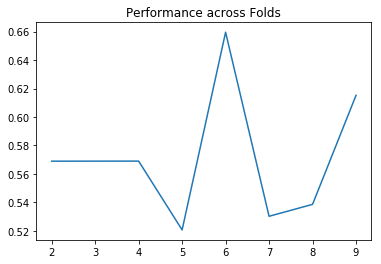

In [320]:
import matplotlib.pyplot as plt
print("Standard Deviation:", np.std(score_list))
print(indices)
plt.figure()
plt.plot(indices, score_list)
plt.title('Performance across Folds')
plt.show()

Which features are important during the time when the datasets are accurate?

In [321]:
indices = [x for x in range(len(score_list)) if score_list[x] > 0.5]
importance = np.array([])
count = 0

for idx in range(0, len(trainDataPartition)): # for several months of 2012, May - end of November, 1180, 1281
    # run random forest
    try:

        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')

        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
    
        # Fit the RF model
        clf = RandomForestClassifier(n_estimators=50, max_depth=1500, random_state=0) # previously 7
        clf.fit(X_train, y_train)

        # print predicitions
        pred = clf.predict(X_test)
    
        if not importance.any():
            print('hi')
            importance = clf.feature_importances_
        else:
            importance = importance + clf.feature_importances_

        count+=1
    except:
        continue #np.nan

    try:
        temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
        score_list.append(temp_score)
        indices.append(idx)
        print(temp_score)
    except:
        pass

hi
0.5689477512425748
0.5690025375756393
0.5206339712918661
0.6595706618962434
0.5302161025052592
0.5385946074922453
0.61524064171123


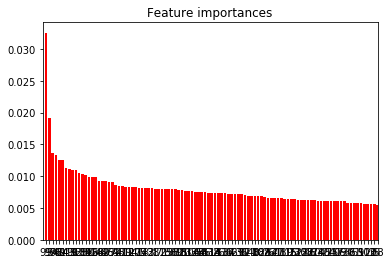

In [322]:
importance = importance / count
feature_indices = np.argsort(importance)[::-1]

# Plot the feature importances of the forest (ERROR HIDDEN, TOO BIG)
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importance[feature_indices],
       color="r", align="center") # X_train.shape[1]
plt.xticks(range(X_train.shape[1]), feature_indices) #X_train.shape[1]
plt.xlim([-1, 100]) #X_train.shape[1]]) 
plt.show()

In [323]:
name = 'Combined_Sets_from_Revised.csv'
df = pd.read_csv(name)
df = df.drop(['Date'], axis = 1)

# Show all the list of features and their respective importances

#listoffeatures = list(train_pd)[1:]
listoffeatures = list(df)
shortlist = []

print('Top Features listed by Importance')

for i in range(len(feature_indices)-1):
    idx = feature_indices[i]
    print(listoffeatures[idx], importance[idx])
    if i <= 25:
        shortlist.append(listoffeatures[idx])
shortlist

Top Features listed by Importance
main98 0.032547854946930535
main96 0.019119054039992946
main93 0.013592680305261515
main95 0.013252520558246593
main68 0.012564630031937585
main83 0.012549761531015408
gfp3 0.011313464528692802
vix18 0.011178232378648388
main90 0.011044137657546468
main91 0.011030078491105672
invest11 0.010499385250520804
invest13 0.010395887192760498
main88 0.010237168873984197
gfp5 0.009868793397333559
main85 0.009856218497265274
invest1 0.009854977688186847
gfp4 0.009311184441166421
main61 0.009309827054509556
main66 0.009286152337792203
main92 0.009105296391363798
main63 0.009086971141057247
main71 0.008666412517134039
main97 0.00852553765108417
main40 0.008485727382150096
main78 0.00836297684032407
main11 0.008285945025411847
invest5 0.008261894756389662
gfp1 0.00823294558056122
vix6 0.008207850341607549
main4 0.008203632402517804
gfp2 0.008180307561250324
main32 0.008139721072370579
main30 0.008124633063718224
main7 0.008028928172253019
main6 0.008009736203567505

['main98',
 'main96',
 'main93',
 'main95',
 'main68',
 'main83',
 'gfp3',
 'vix18',
 'main90',
 'main91',
 'invest11',
 'invest13',
 'main88',
 'gfp5',
 'main85',
 'invest1',
 'gfp4',
 'main61',
 'main66',
 'main92',
 'main63',
 'main71',
 'main97',
 'main40',
 'main78',
 'main11']

# Feature Importance

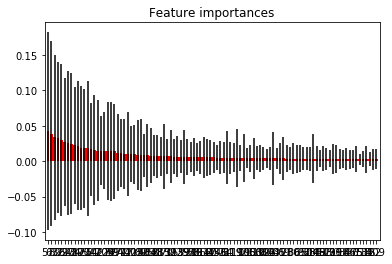

In [32]:
# Create a graph of fetaure importances

import matplotlib.pyplot as plt

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest (ERROR HIDDEN, TOO BIG)
plt.figure()
plt.title("Feature importances")
plt.bar(range(100), importances[indices[0:100]],
       color="r", yerr=std[indices[0:100]], align="center") # X_train.shape[1]
plt.xticks(range(100), indices[0:100]) #X_train.shape[1]
plt.xlim([-1, 100]) #X_train.shape[1]]) 
plt.show()

In [33]:
print(len(clf.feature_importances_))
print(len(list(train_pd)[1:]))

217
218


In [36]:
name = '../Data/Combined_Sets_from_Revised_3.csv'
df = pd.read_csv(name)
df = df.drop(['Date'], axis = 1)

In [37]:
# Show all the list of features and their respective importances

#listoffeatures = list(train_pd)[1:]
listoffeatures = list(df)
shortlist = []

print('Top Features listed by Importance')

for i in range(len(indices)-1):
    idx = indices[i]
    print(listoffeatures[idx], importances[idx])
#    if i <= 50:
#        shortlist.append(listoffeatures[i])

Top Features listed by Importance
main56 0.04246516422174906
main66 0.038890888318713866
main81 0.03352209371117746
main31 0.03316343824589267
main71 0.029538007701172927
main61 0.027638836562973338
main96 0.026174527778898057
main41 0.024717976602409993
main33 0.022179143584261544
main86 0.02192126337972254
google_hits40 0.018536965272188975
main26 0.018094151121507362
main51 0.017907962611983155
main53 0.01662669776174378
main46 0.015511696529390826
main6 0.015034778619333933
invest5 0.014968034625538185
google_hits53 0.014830217360014095
main28 0.01446104855036105
main36 0.013716114196511751
main48 0.01369902198463893
main93 0.012202968050008907
main76 0.011880261213021217
main73 0.010328238974565888
main16 0.010052793341765304
main19 0.009764406723616902
invest3 0.009464639641187931
main11 0.00859702479350911
main88 0.008526362192154482
main39 0.008260623177502284
main24 0.008066004010519183
main82 0.007844714248476117
gfp8 0.007815534136366665
main87 0.007041696130779015
google_hi

# SVM

In [45]:
trainDataPartition, valDataPartition, group = time_cross(train, 0, 410, 50) #10 252 100 Draft_Google_shorter 0.8795

5


In [46]:
test = pd.DataFrame(valDataPartition[1])

In [47]:
splits = group
score = []
good_sets = []
gammas = []

data_size = trainDataPartition[0].shape

for idx in range(len(trainDataPartition)-1):
    try:
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')
        #print(X_train)
        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
        print('train:', sum(y_train), len(y_train))
        print('test:', sum(y_test), len(y_test))
        #print(1 / (X_train.shape[1] * X_train.var()))
        # Fit the RF model

        #gamma =  (1 / (X_train.shape[1] * X_train.var()))
        clf = sklearn.svm.SVC(C=.7, kernel='rbf', gamma='scale') # previously 7
        clf.fit(X_train, y_train)
    except:
        continue

    # print predicitions
    pred = clf.predict(X_test)
    #print(pred)

    # add up AUROCs
            
    try:
        temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
        score.append(temp_score)
        print(temp_score)
        if temp_score > 0.7:
            good_sets.append(idx)
            gammas.append(1 / (X_train.shape[1] * X_train.var()))
    except:
        pass


# calculate average
score = np.mean(score)
print("Averaged Score is: %0.4f" % score, splits)

train: 173 306
test: 40 49
train: 219 388
test: 12 49
train: 178 314
test: 23 49
train: 205 363
test: 22 49
Averaged Score is: nan 5


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
good_sets

In [ ]:
pred_labels2 = []
for predlist in pred_labels:
    for x in range(len(predlist)):
        pred_labels2.append(predlist[x])
pred_labels2

# Test just one giant set
Why: Because if we can get more than 50%, we can get predictions for everything in the training set. Let's see if we can get some kind of "universal" model

In [614]:
file1 = "Combined_Sets_from_Revised_3_Label1.csv" #"Draft_Google_Shorter.csv" #Removed Missing

train_pd = pd.read_csv(file1)
train_pd.shape

(7120, 219)

In [615]:
train_pd = train_pd[6184:]

train = np.array(train_pd)
train.shape

(936, 219)

In [683]:
valDataPartition[7]

array([[1.0, 786.5599980000001, 2.908, ..., 0.0, 0.0, 26.0],
       [1.0, 789.5, 2.891, ..., 0.0, 0.0, 26.0],
       [1.0, 783.119995, 2.944, ..., 0.0, 0.0, 26.0],
       ...,
       [1.0, 683.849976, 1.9669999999999999, ..., 1.0, 1.0, 36.0],
       [1.0, 705.049988, 1.9580000000000002, ..., 1.0, 1.0, 36.0],
       [1.0, 706.179993, 1.996, ..., 1.0, 1.0, 36.0]], dtype=object)